# Model 3: Including Free Text

In the final model we'll build in this post we'll demonstrate how to include free text as a feature alongside the numeric and embedding features we used above.

The key idea here is to include a component in our model that takes a sequence of variable length (in this case an LSTM) and projects that sequence into a feature space with fixed dimmension. Then we'll concatenate this feature representation alongside the numeric features just as we did with the embeddings above. Note that this approach could also work for other non-tabular data sources such as image or video or time series.

Note that to keep the implementation in this post simple we're actually going to restrict the wikipedia descriptions to 250 characters, and if the description has fewer characters we will just pad the sequence to get the full 250. This has the effect of treating the free text data as having a fixed, and not variable, length as promised. However the code below can be easily adjusted to accomodate this by using a batch generator and padding the batches rather than the entire data set once. Again the graphical representation of the model below is helpful.

Out of curiosity we'll get a rough count of about how many words are in each wiki page.

In [1]:
import pandas as pd
df = pd.read_csv('california_housing_enriched.csv.gz')
target = 'median_house_value'
numeric_features = [
    'MedInc',
    'HouseAge',
    'AveRooms',
    'AveBedrms',
    'Population',
    'AveOccup',
    'Latitude',
    'Longitude'
]
categorical_features = [
    'zip_code_encoding',
    'county_encoding',
]
text_features = [
    'county_description'
]
all_features = numeric_features + categorical_features + text_features
X_train = df.loc[df.is_train, all_features]
y_train = df.loc[df.is_train, target]
X_test = df.loc[~df.is_train, all_features]
y_test = df.loc[~df.is_train, target]
X_train.shape, X_test.shape

((16261, 11), (4113, 11))

In [2]:
df.county_description.str.split(' ').apply(len).describe()

count    20374.000000
mean      3434.626141
std       1837.569671
min         47.000000
25%       2299.000000
50%       3341.000000
75%       3508.000000
max       7845.000000
Name: county_description, dtype: float64

In [4]:
import keras
tokenizer = keras.preprocessing.text.Tokenizer(num_words=2000)
tokenizer.fit_on_texts(X_test.county_description)

Using TensorFlow backend.


In [5]:
%%time
X_train_descr = [
    s[:250]
    for s in tokenizer.texts_to_sequences(X_train.county_description)]
X_test_descr = [
    s[:250]
    for s in tokenizer.texts_to_sequences(X_test.county_description)]

CPU times: user 1min 10s, sys: 453 ms, total: 1min 10s
Wall time: 1min 10s


In [137]:
# numeric features
numeric_inputs = keras.layers.Input(shape=(len(numeric_features),), name='numeric_input')
x_numeric = keras.layers.BatchNormalization()(numeric_inputs)


# categorical feature embeddings
zip_code_input = keras.layers.Input(shape=(1,), name='zip_code_input')
zip_code_embedding = keras.layers.Embedding(
    input_dim=X_train.zip_code_encoding.nunique()+1,
    output_dim=3, input_length=1)(zip_code_input)

county_input = keras.layers.Input(shape=(1,), name='county_input')
county_embedding = keras.layers.Embedding(
    input_dim=X_train.zip_code_encoding.nunique()+1,
    output_dim=3, input_length=1)(county_input)
embedding_tensors = [zip_code_embedding, county_embedding]
x_embeddings = keras.layers.Concatenate()([
    keras.layers.Flatten()(embedding) for embedding in embedding_tensors
])


# LSTM input
import keras.backend as K
Sum = keras.layers.Lambda(lambda x: K.sum(x, axis=1))
def Attention(X):
    # https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf
    W = keras.layers.Dense(K.int_shape(X)[-1], activation='tanh')
    u = W(X)
    u_w = keras.layers.Dense(1, activation='linear')
    attention = keras.layers.Softmax(1)(u_w(u))
    X_attended = keras.layers.Multiply()([X, attention])
    return Sum(X_attended), attention

descr_input = keras.layers.Input(shape=(None,), name='descr_input')
descr_embeddings = keras.layers.Embedding(
    input_dim=2000, output_dim=10, input_length=None)(descr_input)
lstm_output = keras.layers.LSTM(10, return_sequences=True)(descr_embeddings)
x_descr, attention = Attention(lstm_output)


x = keras.layers.Concatenate()([x_numeric, x_embeddings, x_descr])
x = keras.layers.Dense(26, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(14, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(1, activation='relu')(x)

model = keras.models.Model(
    inputs=[numeric_inputs, zip_code_input, county_input, descr_input],
    outputs=x)

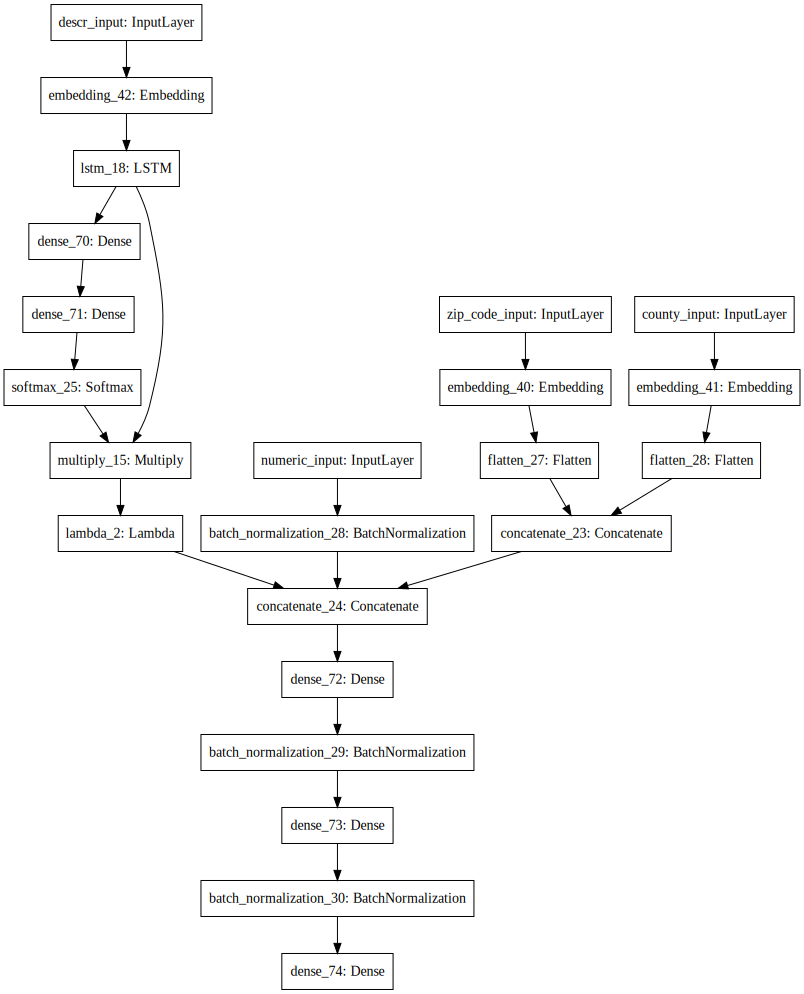

In [138]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [139]:
import numpy as np
X_train_input = {
    'numeric_input': X_train[numeric_features],
    'zip_code_input': X_train['zip_code_encoding'],
    'county_input': X_train['county_encoding'],
    'descr_input': keras.preprocessing.sequence.pad_sequences(X_train_descr, maxlen=250)
}
X_test_input = {
    'numeric_input': X_test[numeric_features],
    'zip_code_input': X_test['zip_code_encoding'],
    'county_input': X_test['county_encoding'],
    'descr_input': keras.preprocessing.sequence.pad_sequences(X_test_descr, maxlen=250)
}

In [140]:
model.compile(loss='mse', optimizer='adam')

In [141]:
model.fit(
    X_train_input, y_train,
    epochs=25,
    validation_data=(X_test_input, y_test),
    callbacks=[keras.callbacks.ReduceLROnPlateau(patience=2), keras.callbacks.EarlyStopping(patience=3)]
)

Train on 16261 samples, validate on 4113 samples
Epoch 1/25
16261/16261 [==============================] - 105s 6ms/step - loss: 1.2761 - val_loss: 0.5342
Epoch 2/25
16261/16261 [==============================] - 101s 6ms/step - loss: 0.5137 - val_loss: 0.4210
Epoch 3/25
16261/16261 [==============================] - 101s 6ms/step - loss: 0.3979 - val_loss: 0.3477
Epoch 4/25
16261/16261 [==============================] - 101s 6ms/step - loss: 0.3471 - val_loss: 0.3805
Epoch 5/25
 2432/16261 [===>..........................] - ETA: 1:23 - loss: 0.3152

KeyboardInterrupt: 

In [142]:
attention_model = keras.models.Model(inputs=descr_input, outputs=attention)
counties, county_descriptions = df[['county', 'county_description']].drop_duplicates().T.values

# process descriptions through the tokenizer
tokens = [s[:250] for s in tokenizer.texts_to_sequences(county_descriptions)]
county_descriptions = [t.split(' ') for t in tokenizer.sequences_to_texts(tokens)]

attention_scores = attention_model.predict(keras.preprocessing.sequence.pad_sequences(tokens, maxlen=250))
# resize the scores to eliminate redundant axis
attention_scores = descr_attention.reshape(descr_attention.shape[:2])

In [143]:
zipped = zip(counties, descr_texts, attention_scores)
word_importances = [
    (county, tuple([(w, i) for w, i in zip(description, description_importances)]))
    for county, description, description_importances in zipped
]

In [144]:
word_importances

[('Contra Costa County',
  (('alameda', 0.0011209763),
   ('county', 0.0003647439),
   ('is', 0.00043995315),
   ('a', 0.0010701225),
   ('county', 0.0003647439),
   ('in', 0.00043709617),
   ('the', 0.00038438846),
   ('state', 0.00030838948),
   ('of', 0.00043345607),
   ('california', 0.00026205007),
   ('in', 0.00043709617),
   ('the', 0.00038438846),
   ('united', 0.00024201865),
   ('states', 0.00025806893),
   ('as', 0.0005331092),
   ('of', 0.00043345607),
   ('the', 0.00038438846),
   ('2010', 0.00036029308),
   ('census', 0.0005575349),
   ('the', 0.00038438846),
   ('population', 0.00025827243),
   ('was', 0.0005329275),
   ('1', 0.0068936143),
   ('510', 0.0027013454),
   ('making', 0.0005804001),
   ('it', 0.00036502522),
   ('the', 0.00038438846),
   ('most', 0.00024297713),
   ('populous', 0.00033990946),
   ('county', 0.0003647439),
   ('in', 0.00043709617),
   ('the', 0.00038438846),
   ('state', 0.00030838948),
   ('the', 0.00038438846),
   ('county', 0.0003647439),
 

In [153]:
county_word_importances = {
    county: sorted(set(importances), key=lambda x: x[-1], reverse=True)[:10]
     for county, importances in word_importances
}
county_word_importances

{'Alameda County': [('portion', 0.26177883),
  ('been', 0.22947454),
  ('southern', 0.11017951),
  ('may', 0.050600987),
  ('wide', 0.030833488),
  ('these', 0.015088022),
  ('great', 0.014200089),
  ('1', 0.00755418),
  ('include', 0.0063419845),
  ('coast', 0.005124288)],
 'Alpine County': [('had', 0.1260566),
  ('3', 0.041744135),
  ('discovery', 0.035626665),
  ('bear', 0.020369474),
  ('during', 0.012601068),
  ('16', 0.012200672),
  ('named', 0.011797871),
  ('11', 0.011002212),
  ('8', 0.009191936),
  ('reported', 0.008524106)],
 'Amador County': [('who', 0.104051225),
  ('3', 0.07386473),
  ('may', 0.06628814),
  ('coroner', 0.037219957),
  ('during', 0.022297125),
  ('named', 0.020875905),
  ('11', 0.01946801),
  ('organized', 0.018159362),
  ('august', 0.017286953),
  ('bureau', 0.014684007)],
 'Butte County': [('once', 0.031008096),
  ('8', 0.030882595),
  ('bureau', 0.027881086),
  ('college', 0.022166764),
  ('agency', 0.01999937),
  ('total', 0.019466717),
  ('1', 0.01879

In [152]:
county_word_importances['Del Norte County']

[('beaches', 0.17491923),
 ('may', 0.08600733),
 ('coastal', 0.070940495),
 ('building', 0.0272597),
 ('great', 0.024136124),
 ('historic', 0.019870106),
 ('bureau', 0.019052157),
 ('notable', 0.017044436),
 ('famous', 0.013011649),
 ('along', 0.012639522)]